In [146]:
# pip install timm medmnist scikit-learn

In [147]:
import os
import torch
import torch.nn as nn
from medmnist import BloodMNIST,INFO
from torchvision import transforms
from collections import Counter
from torch.utils.data import DataLoader,Subset
import random
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import timm
import seaborn as sns

In [119]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
BATCH_SIZE=2
##check the device

device = torch.device('cuda' if torch.cuda.is_available() else 'CPU')
print("Using Device:",device)

Using Device: cuda


In [120]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [121]:
root='./data'
os.makedirs(root, exist_ok=True)

# create train dataset
full_train_dataset = BloodMNIST(split='train',transform=data_transform,download=True,root=root)
subset_train_indices = random.sample(range(len(full_train_dataset)), 100)
small_train_dataset = Subset(full_train_dataset,subset_train_indices)

#############################################################################################################################################
## create test dataset
full_test_dataset = BloodMNIST(split='test',transform=data_transform,download=True,root=root)
subset_test_indices = random.sample(range(len(full_test_dataset)), 100)
small_test_dataset = Subset(full_test_dataset,subset_test_indices)

## create data loaders

train_loader = DataLoader(small_train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(small_test_dataset,batch_size=BATCH_SIZE,shuffle=False)

Using downloaded and verified file: ./data\bloodmnist.npz
Using downloaded and verified file: ./data\bloodmnist.npz


In [122]:
print(f"training samples used:{len(train_loader.dataset)}")
print(f"training samples used:{len(test_loader.dataset)}")

training samples used:100
training samples used:100


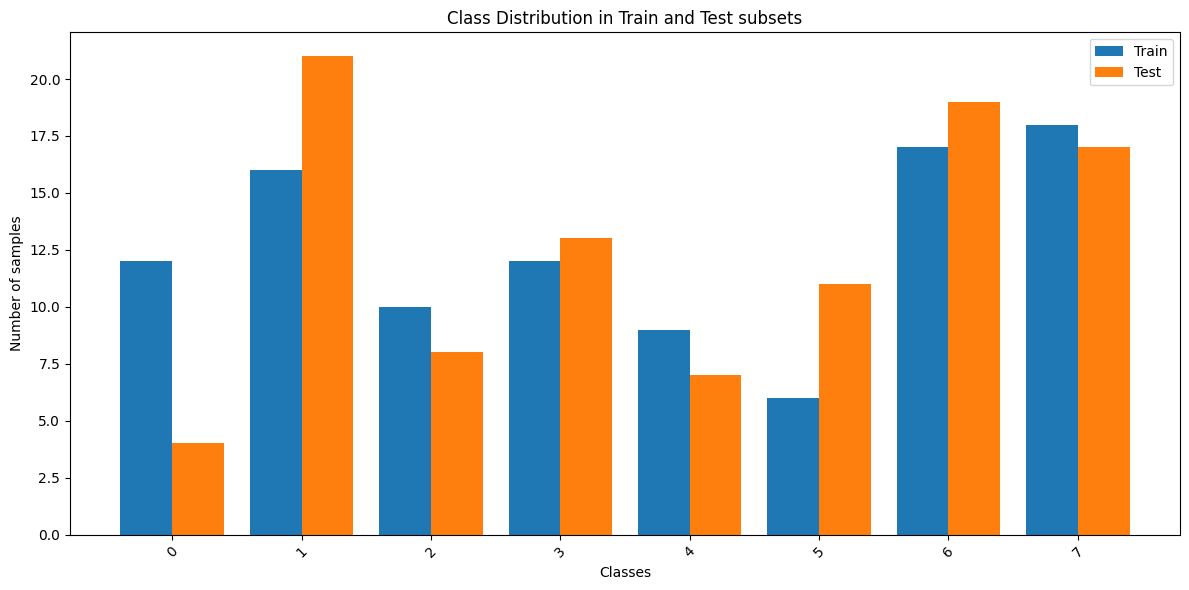

In [123]:
# Function to extract labels from dataset
def get_labels(dataset):
    return [label.item() if isinstance(label, (np.ndarray, torch.Tensor)) else label for _, label in dataset]

train_labels = get_labels(small_train_dataset)
test_labels = get_labels(small_test_dataset)

train_counts, test_counts = Counter(train_labels), Counter(test_labels)
class_names = INFO['bloodmnist']['label']
classes = range(len(class_names))

train_freq = [train_counts.get(i, 0) for i in classes]
test_freq = [test_counts.get(i, 0) for i in classes]

width = 0.4
plt.figure(figsize=(12,6))
plt.bar(classes, train_freq, width=width, label='Train', align='center')
plt.bar([c + width for c in classes], test_freq, width=width, label='Test', align='center')
plt.xticks([c + width/2 for c in classes], class_names, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Distribution in Train and Test subsets')
plt.legend()
plt.tight_layout()
plt.show()

| Input Image   | → | Patch Embedding Layer                                                | → | Patch Embeddings              |
| ------------- | - | -------------------------------------------------------------------- | - | ----------------------------- |
| B x C x H x W | → | ViT Patch Embedding (typically a 2D Conv layer or similar mechanism) | → | B x num\_patches x embed\_dim |


In [124]:
##Define Client Head (Patch Embedding Layer)

class ClientHead(nn.Module):
    def __init__(self, vit_model_name='vit_base_r50_s16_224', pretrained=False):
        super(ClientHead, self).__init__()
        vit = timm.create_model(vit_model_name, pretrained=pretrained)
        self.patch_embed = vit.patch_embed  # ViT's patch embedding layer

    def forward(self, x):
        x = self.patch_embed(x)  # Output shape: [B, num_patches, embed_dim]
        return x

In [125]:
client_head = ClientHead().to(device)
sample_input = next(iter(train_loader))[0].to(device)
patch_embeddings = client_head(sample_input)
print("Patch embeddings shape:", patch_embeddings.shape)

Patch embeddings shape: torch.Size([2, 196, 768])


### What is the ViT Block Sampler?
In your FeSViBS architecture:

1. The server receives patch embeddings from clients.

2. Then, it runs a few blocks of the Vision Transformer (ViT) model — not the entire model, only a subset.

3. This subset is randomly sampled in every round. For example: Block 3 out of 12 total


### Why it’s important:
This is the “Split Learning” point.

1. Instead of running the full ViT model on the server, only selected blocks are run — this reduces computation and enables block sampling.

2. It also serves as feature transformation, passing intermediate representations to the classifier (tail).

In [126]:
# Cell 4: Define the ViT Block Sampler (Partial Transformer Body)
class ViTBlockSampler(nn.Module):
    def __init__(self, vit_model_name='vit_base_r50_s16_224', pretrained=False, total_blocks=12):
        super(ViTBlockSampler, self).__init__()
        self.vit = timm.create_model(vit_model_name, pretrained=pretrained)
        self.blocks = self.vit.blocks  # Full 12 Transformer blocks
        self.norm = self.vit.norm
        self.total_blocks = total_blocks

        self.cls_token = self.vit.cls_token
        self.pos_embed = self.vit.pos_embed
        self.pos_drop = self.vit.pos_drop

    def forward(self, x, chosen_block):
        """
        x: patch embeddings from client (B, N, D)
        chosen_block: number of blocks to run [1 to total_blocks]
        """
        # Add CLS token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)

        for i in range(chosen_block):
            x = self.blocks[i](x)

        x = self.norm(x)
        cls_features = x[:, 0,:]  # extract CLS token features
        return cls_features


### How this fits in the Architecture:
1. The client sends patch embeddings ➡️ server receives them.

2. Server runs only chosen_block ViT layers, not the full stack.

3. Outputs a transformed CLS token, which encodes the global image context (to be classified later).

In [127]:
vit_body = ViTBlockSampler().to(device)
chosen_block = random.randint(1, 6)  # Choose a block between 1 and 6
cls_features = vit_body(patch_embeddings, chosen_block)
print("The chosen block is:", chosen_block)
print("CLS feature shape after block sampling:", cls_features.shape)

The chosen block is: 4
CLS feature shape after block sampling: torch.Size([2, 768])


## Residual Block (Feature Projection Layer)


#### In your architecture diagram, this block:

1. Takes the CLS token features (from the sampled ViT blocks).

2. Applies a 2-layer residual CNN block with dropout and average pooling.

3. It acts as a learnable transformation of features before classification.

#### Why it’s important:
1. Boosts model generalization.

2. Helps capture residual information.

3. Improves performance under non-IID conditions or noisy inputs.

4. Plays the role of server-side feature augmentation in FeSViBS.

In [128]:
# Cell 5: Define ResidualBlock (Projection Network)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels=768, drop_out=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
            #Needed to apply non-linear transformation while maintaining shape.
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
            #Keeps the "identity + residual" structure (like ResNet).
        )
        self.dropout = nn.Dropout2d(p=drop_out)
        self.pool = nn.AvgPool2d(14, stride=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input shape: (B, 768, 14, 14) — we reshape CLS token into spatial format
        if len(x.shape) == 2:  # (B, 768) from CLS token
            x = x.unsqueeze(-1).unsqueeze(-1)  # (B, 768, 1, 1)
            x = x.expand(-1, -1, 14, 14)  # Fake 2D spatial layout to simulate feature map

        residual = x#--------------.
        out = self.conv1(x)        #
        out = self.dropout(out)    #
        out = self.conv2(out)      #
        out += residual#<----------'
        out = self.relu(out)
        out = self.pool(out)  # output shape: (B, 768, 1, 1)
        return out.view(out.size(0), -1)  # flatten to (B, 768)


In [129]:
res_block = ResidualBlock().to(device)
projected = res_block(cls_features)
print("After ResidualBlock shape:", projected.shape)  # Expected: [B, 768]


After ResidualBlock shape: torch.Size([2, 768])


### MLP Tail (Client-Specific Classifier)
1. After the ResidualBlock, the output feature vector (1D: 768) goes into an MLP classifier.

2. It produces final class logits (e.g., for 8 blood cell classes in BloodMNIST).

Each client has its own tail, because:

1. They may learn different data distributions.

2. Federated averaging happens only every few rounds.
### Why it’s important:
1. This is where final classification happens.

2. Also supports client-specific learning.

3. During federation, these tails are aggregated (if enabled in FeSViBS).

In [130]:
# Cell 6: Define MLP Tail Classifier
class MLPClassifier(nn.Module):
    def __init__(self, num_classes=8, hidden_dim=768):
        super(MLPClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Identity(),  # Optional placeholder
            nn.Linear(hidden_dim, num_classes)
            #Converts the feature vector into raw predictions for each class.
        )

    def forward(self, x):
        return self.classifier(x)
    
# Input x: typically of shape (B, 768)
# Returns: output logits of shape (B, 8)

In [131]:
mlp_tail = MLPClassifier(num_classes=8).to(device)
logits = mlp_tail(projected)
print("Logits shape:", logits.shape)  # Expected: [B, 8]


Logits shape: torch.Size([2, 8])


In [132]:
# Simulate Full Forward Pass for One Client/centralized one

# Step 1: Initialize modules
client_head = ClientHead().to(device)
vit_body = ViTBlockSampler().to(device)
res_block = ResidualBlock(drop_out=0.5).to(device)
mlp_tail = MLPClassifier(num_classes=8).to(device)

# Step 2: Load one batch of sample images
sample_batch = next(iter(train_loader))
images = sample_batch[0].to(device)  # shape: [B, 3, 224, 224]
labels = sample_batch[1].to(device)

# Step 3: Client-side forward pass (Patch Embedding)
patch_embeddings = client_head(images)
print("Patch embeddings shape:", patch_embeddings.shape)

# Step 4: Server-side ViT block sampler (choose block L randomly)
chosen_block = random.randint(1, 6)
cls_token_features = vit_body(patch_embeddings, chosen_block)
print("CLS token feature shape:", cls_token_features.shape)

# Step 5: Residual block projection
projected_features = res_block(cls_token_features)
print("Projected feature shape:", projected_features.shape)

# Step 6: MLP classification (tail)
logits = mlp_tail(projected_features)
print("Final output):", logits.shape)


Patch embeddings shape: torch.Size([2, 196, 768])
CLS token feature shape: torch.Size([2, 768])
Projected feature shape: torch.Size([2, 768])
Final output): torch.Size([2, 8])


In [133]:
# Cell 8: Define Cross-Entropy Loss Function
criterion = nn.CrossEntropyLoss()

As we got:
```
logits: output from MLP (shape [B, 8])
labels: ground truth labels from dataset
```

In [134]:
print("Labels shape:", labels.shape)
print("Labels:", labels)
labels = labels.squeeze()  # remove extra dimension if present
print("Labels shape:", labels.shape)
print("Labels:", labels)

Labels shape: torch.Size([2, 1])
Labels: tensor([[3],
        [2]], device='cuda:0')
Labels shape: torch.Size([2])
Labels: tensor([3, 2], device='cuda:0')


In [135]:
# Cell 9: Compute Loss
loss = criterion(logits, labels)
print("Loss:", loss.item())

Loss: 2.547412395477295


In [136]:
# Define Optimizer
optimizer = torch.optim.Adam(
    list(client_head.parameters()) +
    list(vit_body.parameters()) +
    list(res_block.parameters()) +
    list(mlp_tail.parameters()),
    lr=1e-4
)

In [137]:
# Backpropagation and Optimization
optimizer.zero_grad()              # 1. Reset gradients
loss.backward(retain_graph=True)   # 2. Compute gradients
optimizer.step()                   # 3. Update weights

print("Backpropagation complete. Weights updated.")

Backpropagation complete. Weights updated.


In [139]:
# Cell 12: Evaluate model on test data
client_head.eval()
vit_body.eval()
res_block.eval()
mlp_tail.eval()

test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass through full architecture
        patch_embeddings = client_head(images)
        chosen_block = random.randint(1, 6)
        cls_token_features = vit_body(patch_embeddings, chosen_block)
        projected_features = res_block(cls_token_features)
        logits = mlp_tail(projected_features)
        labels = labels.squeeze()
        if len(labels.shape) != 1:
            labels = labels.view(-1)
        loss = criterion(logits, labels)
        test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")



Test Loss: 2.9928


In [140]:
# Cell 13: Compute Balanced Accuracy
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(all_labels, all_preds)
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Balanced Accuracy: 0.1310


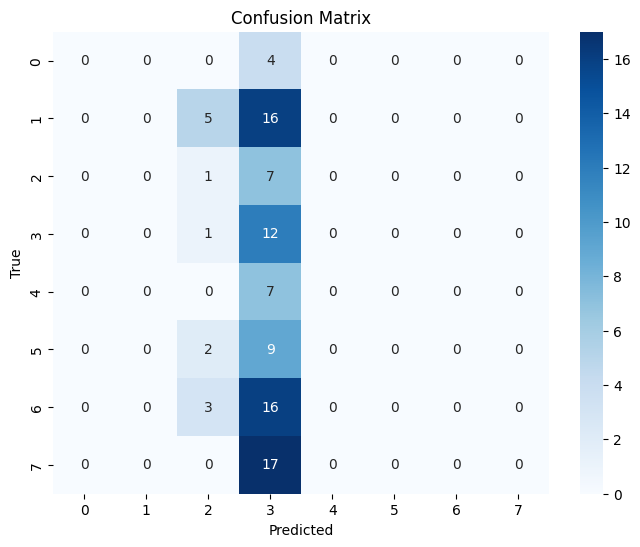

In [149]:
# Cell 14: Confusion Matrix

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [152]:
# Cell 15: Full Training Loop for 1 Client, 1 Epoch

# Re-initialize model components
client_head = ClientHead().to(device)
vit_body = ViTBlockSampler().to(device)
res_block = ResidualBlock().to(device)
mlp_tail = MLPClassifier(num_classes=8).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(client_head.parameters()) +
    list(vit_body.parameters()) +
    list(res_block.parameters()) +
    list(mlp_tail.parameters()),
    lr=1e-4
)

# Store losses
train_losses = []

# ----------- TRAINING ----------
client_head.train()
vit_body.train()
res_block.train()
mlp_tail.train()

for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    patch_embeddings = client_head(images)
    chosen_block = random.randint(1, 6)
    cls_token_features = vit_body(patch_embeddings, chosen_block)
    projected_features = res_block(cls_token_features)
    logits = mlp_tail(projected_features)
    labels = labels.squeeze()
    if len(labels.shape) != 1:
        labels = labels.view(-1)

    # Compute loss and backprop
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if batch_idx % 2 == 0:
        print(f"[Train Batch {batch_idx}] Loss: {loss.item():.4f}")

avg_train_loss = sum(train_losses) / len(train_losses)
print(f"\nAverage Training Loss: {avg_train_loss:.4f}")


[Train Batch 0] Loss: 2.0534
[Train Batch 2] Loss: 4.5017
[Train Batch 4] Loss: 3.1112
[Train Batch 6] Loss: 2.5494
[Train Batch 8] Loss: 3.7763
[Train Batch 10] Loss: 2.8064
[Train Batch 12] Loss: 1.2328
[Train Batch 14] Loss: 4.0052
[Train Batch 16] Loss: 2.1445
[Train Batch 18] Loss: 0.7205
[Train Batch 20] Loss: 0.6190
[Train Batch 22] Loss: 2.5981
[Train Batch 24] Loss: 3.8965
[Train Batch 26] Loss: 3.1732
[Train Batch 28] Loss: 2.6032
[Train Batch 30] Loss: 2.7123
[Train Batch 32] Loss: 3.1402
[Train Batch 34] Loss: 0.2413
[Train Batch 36] Loss: 0.8890
[Train Batch 38] Loss: 1.3304
[Train Batch 40] Loss: 2.6869
[Train Batch 42] Loss: 2.0886
[Train Batch 44] Loss: 1.5346
[Train Batch 46] Loss: 2.5039
[Train Batch 48] Loss: 2.0649

Average Training Loss: 2.4856


In [154]:
# Cell 16: Evaluation After Training

client_head.eval()
vit_body.eval()
res_block.eval()
mlp_tail.eval()

test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        patch_embeddings = client_head(images)
        chosen_block = random.randint(1, 6)
        cls_token_features = vit_body(patch_embeddings, chosen_block)
        projected_features = res_block(cls_token_features)
        logits = mlp_tail(projected_features)
        labels = labels.squeeze()
        if len(labels.shape) != 1:
            labels = labels.view(-1)

        loss = criterion(logits, labels)
        test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
balanced_acc = balanced_accuracy_score(all_labels, all_preds)

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")



Test Loss: 1.7568
Balanced Accuracy: 0.3003


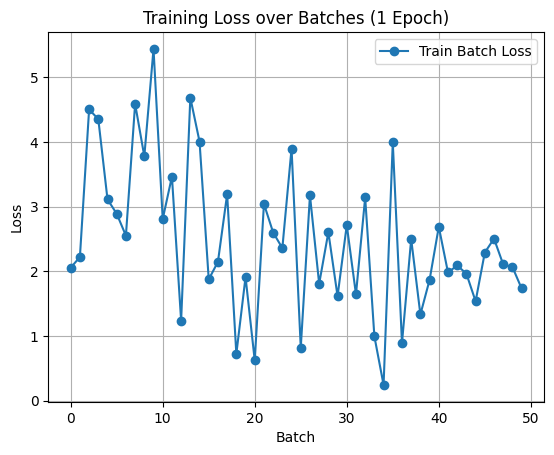

In [155]:
# Cell 17: Plot Training Loss
plt.plot(train_losses, marker='o', label='Train Batch Loss')
plt.title("Training Loss over Batches (1 Epoch)")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## FeSViBS Multi-Client

In each federated round:

### 1. Each client:

* Trains independently using:
* Its own head

* Shared ViT body (partial blocks on server)

* Its own tail

* Sends gradients/features to server for forward/backward pass

### 2. The server:

* Aggregates weights of:

* Selected ViT blocks (block-wise sampling)

* Optionally heads/tails every N rounds using FedAvg

In [156]:
# Cell 18: IID Split Across Clients
num_clients = 3
subset_size = len(small_train_dataset) // num_clients

client_loaders = []

for i in range(num_clients):
    indices = list(range(i * subset_size, (i + 1) * subset_size))
    client_subset = Subset(small_train_dataset, indices)
    client_loader = DataLoader(client_subset, batch_size=10, shuffle=True)
    client_loaders.append(client_loader)

print(f"{num_clients} clients created, each with {subset_size} samples")


3 clients created, each with 33 samples


In [157]:
# Initialize Models Per Client
client_heads = [ClientHead().to(device) for _ in range(num_clients)]
mlp_tails = [MLPClassifier(num_classes=8).to(device) for _ in range(num_clients)]

# Shared server components
vit_body = ViTBlockSampler().to(device)
res_block = ResidualBlock().to(device)

criterion = nn.CrossEntropyLoss()

# Define separate optimizers per client
optimizers = [
    torch.optim.Adam(
        list(client_heads[i].parameters()) + list(mlp_tails[i].parameters()),
        lr=1e-4
    ) for i in range(num_clients)
]

# Shared optimizer for ViT blocks and residual
server_optimizer = torch.optim.Adam(
    list(vit_body.parameters()) + list(res_block.parameters()),
    lr=1e-4
)


In [161]:
# Cell 20: One Federated Round of Training
from copy import deepcopy

num_rounds = 5
local_epochs = 1

for rnd in range(num_rounds):
    print(f"\n===== Federated Round {rnd + 1} =====")
    
    local_client_weights = []  # Store weights to be averaged later

    for client_id in range(num_clients):
        client_head = client_heads[client_id]
        mlp_tail = mlp_tails[client_id]
        optimizer = optimizers[client_id]
        loader = client_loaders[client_id]

        client_head.train()
        mlp_tail.train()
        vit_body.train()
        res_block.train()

        for epoch in range(local_epochs):
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)

                patch_embeddings = client_head(images)
                chosen_block = random.randint(1, 6)
                cls_token = vit_body(patch_embeddings, chosen_block)
                projected = res_block(cls_token)
                logits = mlp_tail(projected)
                labels = labels.squeeze()
                if len(labels.shape) != 1:
                    labels = labels.view(-1)

                loss = criterion(logits, labels)
                optimizer.zero_grad()
                server_optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                server_optimizer.step()
        
        # Store client weights for head and tail
        local_client_weights.append({
            'head': deepcopy(client_head.state_dict()),
            'tail': deepcopy(mlp_tail.state_dict())
        })



===== Federated Round 1 =====

===== Federated Round 2 =====

===== Federated Round 3 =====

===== Federated Round 4 =====

===== Federated Round 5 =====


In [162]:
# Cell 21: FedAvg of Heads and Tails
def fed_avg(state_dicts):
    avg_state = deepcopy(state_dicts[0])
    for key in avg_state:
        for i in range(1, len(state_dicts)):
            avg_state[key] += state_dicts[i][key]
        avg_state[key] = avg_state[key] / len(state_dicts)
    return avg_state

# Aggregate heads and tails
avg_head = fed_avg([w['head'] for w in local_client_weights])
avg_tail = fed_avg([w['tail'] for w in local_client_weights])

# Load back into clients
for i in range(num_clients):
    client_heads[i].load_state_dict(avg_head)
    mlp_tails[i].load_state_dict(avg_tail)

print("FedAvg aggregation complete.")


FedAvg aggregation complete.


In [165]:
num_rounds = 5  # 🔁 Multi-round training
# Track metrics per round
round_test_losses = []
round_balanced_accuracies = []

for rnd in range(num_rounds):
    print(f"\n===== Federated Round {rnd + 1} =====")
    local_client_weights = []

    for client_id in range(num_clients):
        ...
        # (Same training loop per client as before)
        ...
        local_client_weights.append({
            'head': deepcopy(client_head.state_dict()),
            'tail': deepcopy(mlp_tail.state_dict())
        })

    # Federated Aggregation
    avg_head = fed_avg([w['head'] for w in local_client_weights])
    avg_tail = fed_avg([w['tail'] for w in local_client_weights])
    
    for i in range(num_clients):
        client_heads[i].load_state_dict(avg_head)
        mlp_tails[i].load_state_dict(avg_tail)

    print("FedAvg aggregation complete.")

    # Optional: Evaluate on test set after each round
    client_head = client_heads[0]  # Evaluate one client
    mlp_tail = mlp_tails[0]
    client_head.eval()
    mlp_tail.eval()
    vit_body.eval()
    res_block.eval()

    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            patch_embeddings = client_head(images)
            chosen_block = random.randint(1, 6)
            cls_token = vit_body(patch_embeddings, chosen_block)
            projected = res_block(cls_token)
            logits = mlp_tail(projected)
            labels = labels.squeeze()
            if len(labels.shape) != 1:
                labels = labels.view(-1)

            loss = criterion(logits, labels)
            test_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    round_test_losses.append(avg_test_loss)
    round_balanced_accuracies.append(balanced_acc)


    print(f"[Round {rnd+1}] Test Loss: {avg_test_loss:.4f} | Balanced Acc: {balanced_acc:.4f}")



===== Federated Round 1 =====
FedAvg aggregation complete.
[Round 1] Test Loss: 1.1472 | Balanced Acc: 0.4356

===== Federated Round 2 =====
FedAvg aggregation complete.
[Round 2] Test Loss: 1.1745 | Balanced Acc: 0.4985

===== Federated Round 3 =====
FedAvg aggregation complete.
[Round 3] Test Loss: 1.1211 | Balanced Acc: 0.5367

===== Federated Round 4 =====
FedAvg aggregation complete.
[Round 4] Test Loss: 1.2721 | Balanced Acc: 0.4401

===== Federated Round 5 =====
FedAvg aggregation complete.
[Round 5] Test Loss: 1.2028 | Balanced Acc: 0.4614


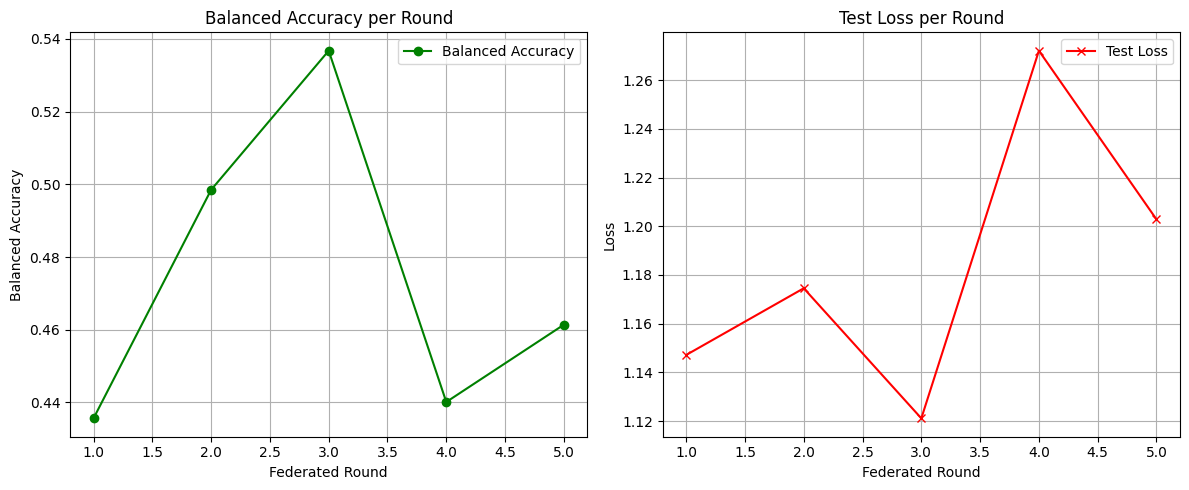

In [166]:
# Cell: Plot Accuracy and Loss over Rounds
rounds = list(range(1, num_rounds + 1))

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rounds, round_balanced_accuracies, marker='o', color='green', label='Balanced Accuracy')
plt.title("Balanced Accuracy per Round")
plt.xlabel("Federated Round")
plt.ylabel("Balanced Accuracy")
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rounds, round_test_losses, marker='x', color='red', label='Test Loss')
plt.title("Test Loss per Round")
plt.xlabel("Federated Round")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [167]:
# Cell 23: Create Non-IID Data Loaders for Clients
from collections import defaultdict

def create_noniid_loaders(dataset, num_clients=3, classes_per_client=2):
    # Step 1: Group indices by class
    class_indices = defaultdict(list)
    for idx, (img, label) in enumerate(dataset):
        class_indices[int(label)].append(idx)

    # Step 2: Assign specific classes to each client
    client_class_map = {}
    all_classes = list(class_indices.keys())
    random.shuffle(all_classes)
    
    for client_id in range(num_clients):
        start = (client_id * classes_per_client) % len(all_classes)
        assigned_classes = all_classes[start: start + classes_per_client]
        client_class_map[client_id] = assigned_classes

    # Step 3: Gather indices for each client
    client_indices = defaultdict(list)
    for client_id, class_list in client_class_map.items():
        for cls in class_list:
            cls_samples = class_indices[cls]
            sample_count = min(30, len(cls_samples))  # limit per class
            client_indices[client_id].extend(random.sample(cls_samples, sample_count))

    # Step 4: Create client-specific DataLoaders
    client_loaders = []
    for client_id in range(num_clients):
        subset = Subset(dataset, client_indices[client_id])
        loader = DataLoader(subset, batch_size=10, shuffle=True)
        client_loaders.append(loader)
        print(f"Client {client_id} → Classes {client_class_map[client_id]}, Samples: {len(subset)}")

    return client_loaders


In [172]:
client_loaders = create_noniid_loaders(small_train_dataset, num_clients=4, classes_per_client=2)

Client 0 → Classes [5, 1], Samples: 22
Client 1 → Classes [4, 7], Samples: 27
Client 2 → Classes [2, 6], Samples: 27
Client 3 → Classes [0, 3], Samples: 24


C:\Users\user\AppData\Local\Temp\ipykernel_22076\3226126421.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_indices[int(label)].append(idx)


In [173]:
# Visualize non-IID label distribution
for i, loader in enumerate(client_loaders):
    label_counts = defaultdict(int)
    for _, labels in loader:
        for label in labels:
            label_counts[int(label)] += 1
    print(f"Client {i} Label Distribution: {dict(label_counts)}")


Client 0 Label Distribution: {1: 16, 5: 6}
Client 1 Label Distribution: {7: 18, 4: 9}
Client 2 Label Distribution: {6: 17, 2: 10}
Client 3 Label Distribution: {3: 12, 0: 12}


In [174]:
# # Cell 18: IID Split Across Clients
# num_clients = 3
# subset_size = len(small_train_dataset) // num_clients

# client_loaders = []

# for i in range(num_clients):
#     indices = list(range(i * subset_size, (i + 1) * subset_size))
#     client_subset = Subset(small_train_dataset, indices)
#     client_loader = DataLoader(client_subset, batch_size=10, shuffle=True)
#     client_loaders.append(client_loader)

# print(f"{num_clients} clients created, each with {subset_size} samples")


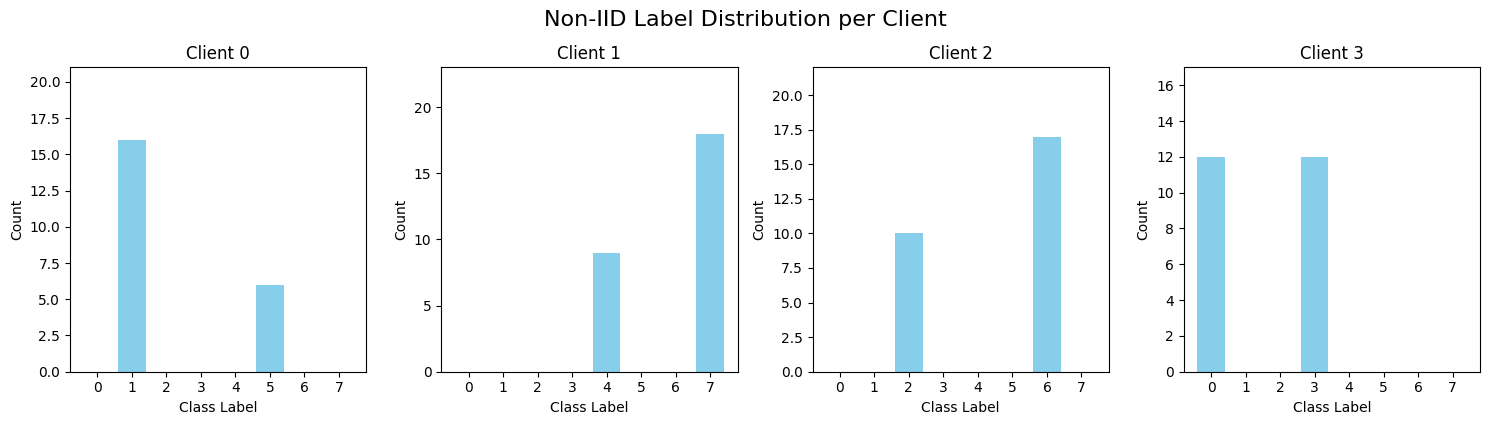

In [175]:
#  Print Non-IID Label Distribution for Each Client

def plot_noniid_distribution(client_loaders):
    num_clients = len(client_loaders)
    num_classes = 8  # For BloodMNIST

    plt.figure(figsize=(15, 4))

    for i, loader in enumerate(client_loaders):
        class_counts = [0] * num_classes
        for _, labels in loader:
            for label in labels:
                class_counts[int(label)] += 1
        
        plt.subplot(1, num_clients, i + 1)
        plt.bar(range(num_classes), class_counts, color='skyblue')
        plt.title(f"Client {i}")
        plt.xlabel("Class Label")
        plt.ylabel("Count")
        plt.xticks(range(num_classes))
        plt.ylim(0, max(class_counts) + 5)

    plt.tight_layout()
    plt.suptitle("Non-IID Label Distribution per Client", fontsize=16, y=1.05)
    plt.show()

# Call this after creating client_loaders
plot_noniid_distribution(client_loaders)


In [178]:
# Cell 25: Train on Non-IID Clients (FeSViBS)

num_clients = len(client_loaders)
num_rounds = 5
local_epochs = 1

# Re-initialize model components
client_heads = [ClientHead().to(device) for _ in range(num_clients)]
mlp_tails = [MLPClassifier(num_classes=8).to(device) for _ in range(num_clients)]

vit_body = ViTBlockSampler().to(device)
res_block = ResidualBlock().to(device)

criterion = nn.CrossEntropyLoss()

optimizers = [
    torch.optim.Adam(
        list(client_heads[i].parameters()) + list(mlp_tails[i].parameters()),
        lr=1e-4
    ) for i in range(num_clients)
]

server_optimizer = torch.optim.Adam(
    list(vit_body.parameters()) + list(res_block.parameters()),
    lr=1e-4
)

# Track metrics
round_test_losses = []
round_balanced_accuracies = []

for rnd in range(num_rounds):
    print(f"\n===== Federated Round {rnd + 1} =====")
    local_client_weights = []

    for client_id in range(num_clients):
        client_head = client_heads[client_id]
        mlp_tail = mlp_tails[client_id]
        optimizer = optimizers[client_id]
        loader = client_loaders[client_id]

        client_head.train()
        mlp_tail.train()
        vit_body.train()
        res_block.train()

        for epoch in range(local_epochs):
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)

                patch_embeddings = client_head(images)
                chosen_block = random.randint(1, 6)
                cls_token = vit_body(patch_embeddings, chosen_block)
                projected = res_block(cls_token)
                logits = mlp_tail(projected)
                labels = labels.squeeze()

                loss = criterion(logits, labels)
                optimizer.zero_grad()
                server_optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                server_optimizer.step()

        # Save client weights (for FedAvg)
        local_client_weights.append({
            'head': deepcopy(client_head.state_dict()),
            'tail': deepcopy(mlp_tail.state_dict())
        })

    # FedAvg across all heads and tails
    avg_head = fed_avg([w['head'] for w in local_client_weights])
    avg_tail = fed_avg([w['tail'] for w in local_client_weights])
    for i in range(num_clients):
        client_heads[i].load_state_dict(avg_head)
        mlp_tails[i].load_state_dict(avg_tail)

    print("FedAvg aggregation complete.")

    # ----- Evaluation after round (on global test set using one client) -----
    client_head = client_heads[0]
    mlp_tail = mlp_tails[0]
    client_head.eval()
    mlp_tail.eval()
    vit_body.eval()
    res_block.eval()

    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            patch_embeddings = client_head(images)
            chosen_block = random.randint(1, 6)
            cls_token = vit_body(patch_embeddings, chosen_block)
            projected = res_block(cls_token)
            logits = mlp_tail(projected)
            labels = labels.squeeze()

            loss = criterion(logits, labels)
            test_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    round_test_losses.append(avg_test_loss)
    round_balanced_accuracies.append(balanced_acc)

    print(f"[Round {rnd+1}] Test Loss: {avg_test_loss:.4f} | Balanced Acc: {balanced_acc:.4f}")



===== Federated Round 1 =====
FedAvg aggregation complete.
[Round 1] Test Loss: 2.0870 | Balanced Acc: 0.1310

===== Federated Round 2 =====
FedAvg aggregation complete.
[Round 2] Test Loss: 1.9206 | Balanced Acc: 0.2243

===== Federated Round 3 =====
FedAvg aggregation complete.
[Round 3] Test Loss: 2.0064 | Balanced Acc: 0.2513

===== Federated Round 4 =====
FedAvg aggregation complete.
[Round 4] Test Loss: 2.0384 | Balanced Acc: 0.1980

===== Federated Round 5 =====
FedAvg aggregation complete.
[Round 5] Test Loss: 2.5156 | Balanced Acc: 0.1854


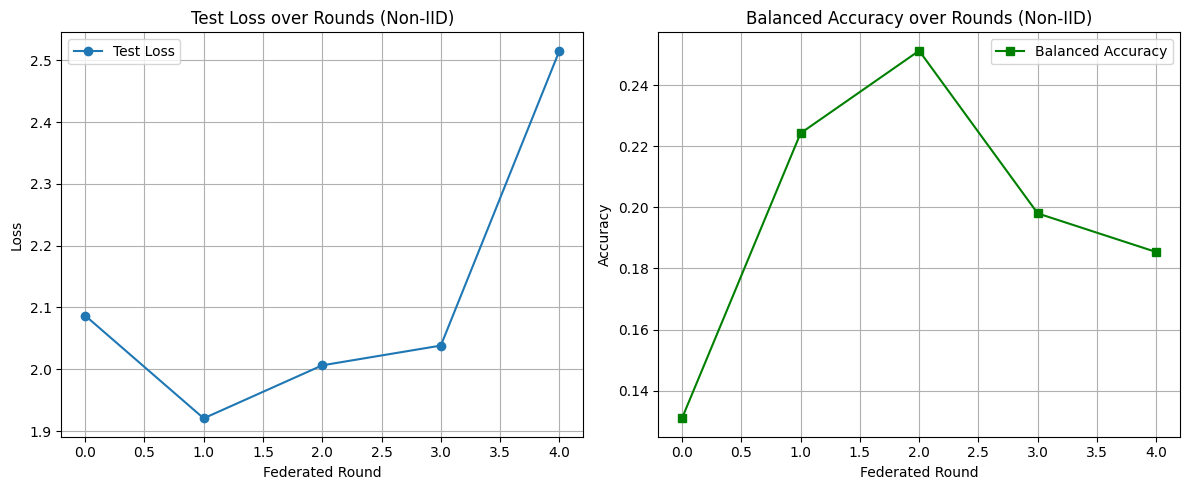

In [179]:
# Cell 26: Plot Metrics Over Federated Rounds
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(round_test_losses, marker='o', label='Test Loss')
plt.title("Test Loss over Rounds (Non-IID)")
plt.xlabel("Federated Round")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(round_balanced_accuracies, marker='s', color='green', label='Balanced Accuracy')
plt.title("Balanced Accuracy over Rounds (Non-IID)")
plt.xlabel("Federated Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [183]:
# Cell 27: Unified Federated Training Function
def train_fesvibs(client_loaders, num_rounds=5, local_epochs=1):
    num_clients = len(client_loaders)

    # Initialize client-specific and shared models
    client_heads = [ClientHead().to(device) for _ in range(num_clients)]
    mlp_tails = [MLPClassifier(num_classes=8).to(device) for _ in range(num_clients)]

    vit_body = ViTBlockSampler().to(device)
    res_block = ResidualBlock().to(device)

    criterion = nn.CrossEntropyLoss()

    optimizers = [
        torch.optim.Adam(
            list(client_heads[i].parameters()) + list(mlp_tails[i].parameters()),
            lr=1e-4
        ) for i in range(num_clients)
    ]

    server_optimizer = torch.optim.Adam(
        list(vit_body.parameters()) + list(res_block.parameters()),
        lr=1e-4
    )

    round_test_losses = []
    round_balanced_accuracies = []

    for rnd in range(num_rounds):
        print(f"\n[Round {rnd+1}/{num_rounds}]")
        local_client_weights = []

        for client_id in range(num_clients):
            client_head = client_heads[client_id]
            mlp_tail = mlp_tails[client_id]
            optimizer = optimizers[client_id]
            loader = client_loaders[client_id]

            client_head.train()
            mlp_tail.train()
            vit_body.train()
            res_block.train()

            for epoch in range(local_epochs):
                for images, labels in loader:
                    images = images.to(device)
                    labels = labels.to(device)

                    patch_embeddings = client_head(images)
                    chosen_block = random.randint(1, 6)
                    cls_token = vit_body(patch_embeddings, chosen_block)
                    projected = res_block(cls_token)
                    logits = mlp_tail(projected)
                    labels = labels.squeeze()
                    loss = criterion(logits, labels)
                    optimizer.zero_grad()
                    server_optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    server_optimizer.step()

            local_client_weights.append({
                'head': deepcopy(client_head.state_dict()),
                'tail': deepcopy(mlp_tail.state_dict())
            })

        # FedAvg
        avg_head = fed_avg([w['head'] for w in local_client_weights])
        avg_tail = fed_avg([w['tail'] for w in local_client_weights])
        for i in range(num_clients):
            client_heads[i].load_state_dict(avg_head)
            mlp_tails[i].load_state_dict(avg_tail)

        # Evaluate using client 0
        client_head = client_heads[0]
        mlp_tail = mlp_tails[0]
        client_head.eval()
        mlp_tail.eval()
        vit_body.eval()
        res_block.eval()

        test_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                patch_embeddings = client_head(images)
                chosen_block = random.randint(1, 6)
                cls_token = vit_body(patch_embeddings, chosen_block)
                projected = res_block(cls_token)
                logits = mlp_tail(projected)
                labels= labels.squeeze()
                loss = criterion(logits, labels)
                test_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        balanced_acc = balanced_accuracy_score(all_labels, all_preds)
        round_test_losses.append(avg_test_loss)
        round_balanced_accuracies.append(balanced_acc)

        print(f"Loss: {avg_test_loss:.4f}, Balanced Acc: {balanced_acc:.4f}")

    return round_test_losses, round_balanced_accuracies


In [199]:
# IID setup
def create_iid_loaders(dataset, num_clients=5):
    subset_size = len(dataset) // num_clients
    client_loaders = []
    for i in range(num_clients):
        indices = list(range(i * subset_size, (i + 1) * subset_size))
        subset = Subset(dataset, indices)
        loader = DataLoader(subset, batch_size=10, shuffle=True)
        client_loaders.append(loader)
    return client_loaders

iid_loaders = create_iid_loaders(small_train_dataset)
noniid_loaders = create_noniid_loaders(small_train_dataset, num_clients=5, classes_per_client=2)


Client 0 → Classes [6, 4], Samples: 26
Client 1 → Classes [0, 7], Samples: 30
Client 2 → Classes [1, 2], Samples: 26
Client 3 → Classes [3, 5], Samples: 18
Client 4 → Classes [6, 4], Samples: 26


C:\Users\user\AppData\Local\Temp\ipykernel_22076\3226126421.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_indices[int(label)].append(idx)


In [200]:
# Run both setups
print("\n====== IID Training ======")
iid_losses, iid_accs = train_fesvibs(iid_loaders, num_rounds=5)

print("\n====== Non-IID Training ======")
noniid_losses, noniid_accs = train_fesvibs(noniid_loaders, num_rounds=5)



====== IID Training ======

[Round 1/5]
Loss: 2.2658, Balanced Acc: 0.0997

[Round 2/5]
Loss: 1.5681, Balanced Acc: 0.2692

[Round 3/5]
Loss: 1.4895, Balanced Acc: 0.3322

[Round 4/5]
Loss: 1.1755, Balanced Acc: 0.4099

[Round 5/5]
Loss: 1.0814, Balanced Acc: 0.4744

====== Non-IID Training ======

[Round 1/5]
Loss: 2.2829, Balanced Acc: 0.1250

[Round 2/5]
Loss: 1.9878, Balanced Acc: 0.2095

[Round 3/5]
Loss: 2.0807, Balanced Acc: 0.2079

[Round 4/5]
Loss: 1.8227, Balanced Acc: 0.3715

[Round 5/5]
Loss: 1.5287, Balanced Acc: 0.4819


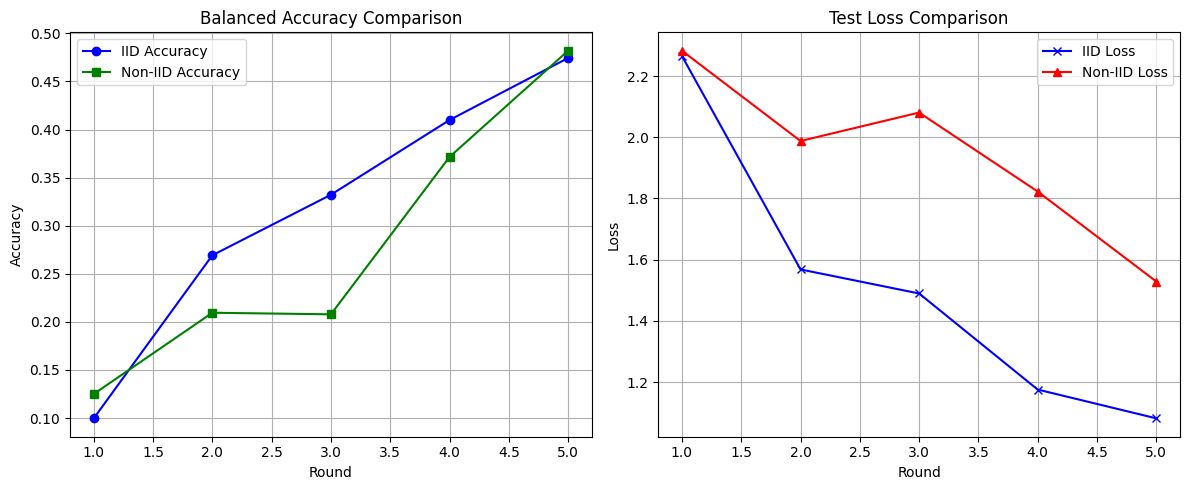

In [201]:
# Cell 30: Compare IID vs Non-IID Performance
rounds = list(range(1, 6))

plt.figure(figsize=(12, 5))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(rounds, iid_accs, marker='o', label='IID Accuracy', color='blue')
plt.plot(rounds, noniid_accs, marker='s', label='Non-IID Accuracy', color='green')
plt.title("Balanced Accuracy Comparison")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(rounds, iid_losses, marker='x', label='IID Loss', color='blue')
plt.plot(rounds, noniid_losses, marker='^', label='Non-IID Loss', color='red')
plt.title("Test Loss Comparison")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [202]:
# Cell 31: Count label distribution per client
from collections import defaultdict

def count_labels_per_client(client_loaders, num_classes=8):
    label_matrix = []

    for loader in client_loaders:
        label_counts = [0] * num_classes
        for _, labels in loader:
            for label in labels:
                label_counts[int(label)] += 1
        label_matrix.append(label_counts)
    
    return np.array(label_matrix).T  # Shape: [num_classes, num_clients]


In [203]:
# Cell 32: Plot stacked bar chart for label distribution

def plot_stacked_distribution(iid_matrix, noniid_matrix, num_clients=3, num_classes=8):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    x = np.arange(num_clients)
    class_labels = [f"Class {i}" for i in range(num_classes)]
    colors = plt.cm.get_cmap('tab20', num_classes).colors

    # Plot IID
    bottom = np.zeros(num_clients)
    for i in range(num_classes):
        axes[0].bar(x, iid_matrix[i], bottom=bottom, color=colors[i], label=class_labels[i])
        bottom += iid_matrix[i]
    axes[0].set_title("IID Client Class Distribution")
    axes[0].set_xlabel("Client")
    axes[0].set_ylabel("Sample Count")
    axes[0].set_xticks(x)
    axes[0].legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.25, 1))

    # Plot Non-IID
    bottom = np.zeros(num_clients)
    for i in range(num_classes):
        axes[1].bar(x, noniid_matrix[i], bottom=bottom, color=colors[i], label=class_labels[i])
        bottom += noniid_matrix[i]
    axes[1].set_title("Non-IID Client Class Distribution")
    axes[1].set_xlabel("Client")
    axes[1].set_xticks(x)

    plt.tight_layout()
    plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22076\764296847.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes).colors


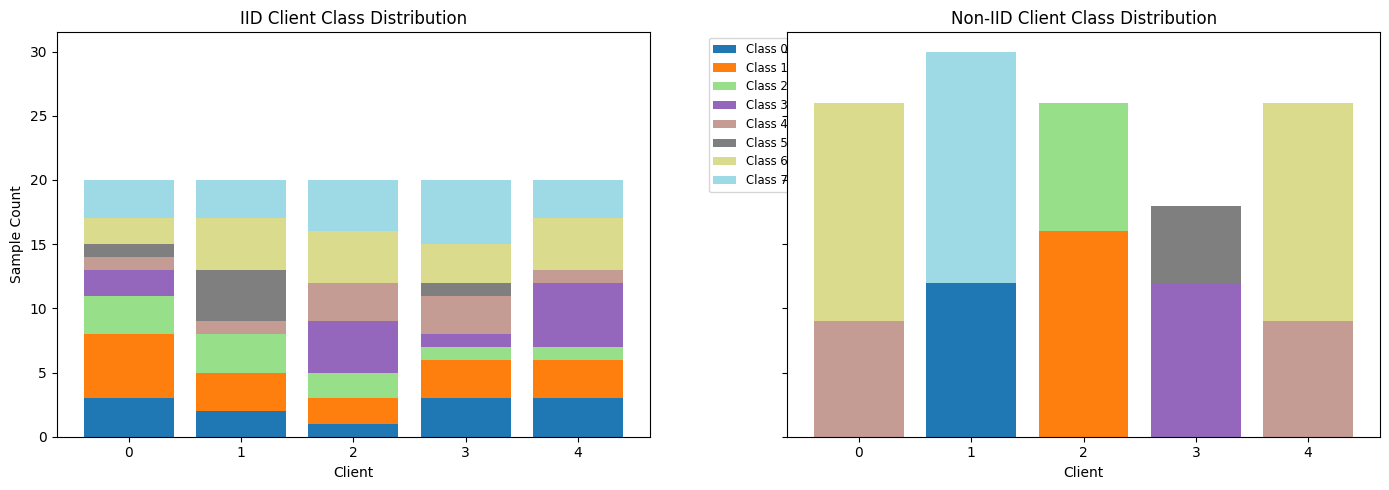

In [204]:
# Cell 33: Generate and Plot Distribution Comparison

iid_matrix = count_labels_per_client(iid_loaders)
noniid_matrix = count_labels_per_client(noniid_loaders)

plot_stacked_distribution(iid_matrix, noniid_matrix, num_clients=5, num_classes=8)
